<a href="https://colab.research.google.com/github/meedastitou/computer-vision/blob/main/prepare_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Personal Protective Equipment (PPE) dataset
## **Objective**
The goal of this project is to develop a robust object detection model using **YOLOv8** to identify and classify **Personal Protective Equipment (PPE)** in images. Ensuring proper usage of PPE is critical in industries such as construction, manufacturing, healthcare, and mining to safeguard workers from potential hazards. This model will assist in automating PPE compliance checks by detecting items like:
- **Helmet**
- **Vests**
- **Gloves**
- **Glasses**
- **Shoes**
  
By leveraging deep learning techniques, we aim to build a system that can be deployed in real-time monitoring or post-processing scenarios to enhance workplace safety.

---

In [1]:
# Install required libraries
!pip install ultralytics opencv-python matplotlib tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 90.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 72.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
!unzip "/content/drive/MyDrive/Construction Site Safety Image Dataset.zip" -d "/content/data"

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: /content/data/Construction Site Safety Image Dataset/css-data/train/images/class1_075_jpg.rf.e3831cb374ca34da6761df50b874cbc9.jpg  
  inflating: /content/data/Construction Site Safety Image Dataset/css-data/train/images/class1_075_jpg.rf.f7bb65e5958e262cf9b3ab5ea58eb1c3.jpg  
  inflating: /content/data/Construction Site Safety Image Dataset/css-data/train/images/class1_199_jpg.rf.2250978db6c0152db7ef02b384754b37.jpg  
  inflating: /content/data/Construction Site Safety Image Dataset/css-data/train/images/class1_199_jpg.rf.25ac2f354750de8592d134101f96dec8.jpg  
  inflating: /content/data/Construction Site Safety Image Dataset/css-data/train/images/class1_199_jpg.rf.40b9ed9b838a4ec0c2fe23d234a34914.jpg  
  inflating: /content/data/Construction Site Safety Image Dataset/css-data/train/images/class1_199_jpg.rf.613bff69919975a0c19a8b77c7f2b139.jpg  
  inflating: /content/data/Construction Site Safety 

In [4]:


# Import necessary modules
import os
import re
import glob
import random
import yaml
from typing import Literal
import time
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
import shutil

import IPython.display as display
from PIL import Image
import cv2

from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [5]:
class CFG:
    SEED = 42
    DATASET_PATH = ['/content/data/Construction Site Safety Image Dataset/css-data/']
    ARTIFACTS_DATA = '/content//drive/MyDrive/dataset'

    # Classes
    CLASSES = ['Gloves', 'Glasses', 'Shoes', 'Helmet', 'Vest', 'Person']
    NUM_CLASSES_TO_TRAIN = len(CLASSES)
    MODE = ['train', 'test', 'valid']


    #Train

In [6]:
os.makedirs(CFG.ARTIFACTS_DATA, exist_ok=True)


## CREATE YAML FILE
* Create data.yaml used by Yolo

In [7]:
dict_yaml_file = {
    'train': os.path.join(CFG.DATASET_PATH[0], 'train'),
    'test' : os.path.join(CFG.DATASET_PATH[0], 'test'),
    'val'  : os.path.join(CFG.DATASET_PATH[0], 'val'),
    'nc'   : CFG.NUM_CLASSES_TO_TRAIN,
    'names': CFG.CLASSES
}

In [8]:
def create_yaml_file(file_path = CFG.ARTIFACTS_DATA, data = dict_yaml_file):

    with open(os.path.join(file_path, 'data.yaml'), 'w+') as file:
        yaml.dump(data, file)

In [9]:
def read_yaml_file(file_path = CFG.ARTIFACTS_DATA):
    with open(os.path.join(file_path, 'data.yaml'), 'r') as file:
        try :
            return yaml.safe_load(file)
        except yaml.YAMLError as e:
            print(e)
        except Exception as e:
            print(e)

In [10]:
### print it with newlines
def print_yaml_data(data):
    formatted_yaml = yaml.dump(data, default_style=False)
    print(formatted_yaml)

In [11]:
create_yaml_file()

In [12]:
yaml_data = read_yaml_file()

In [13]:
yaml_data

{'names': ['Gloves', 'Glasses', 'Shoes', 'Helmet', 'Vest', 'Person'],
 'nc': 6,
 'test': '/content/data/Construction Site Safety Image Dataset/css-data/test',
 'train': '/content/data/Construction Site Safety Image Dataset/css-data/train',
 'val': '/content/data/Construction Site Safety Image Dataset/css-data/val'}

In [14]:
print_yaml_data(yaml_data)

names:
- Gloves
- Glasses
- Shoes
- Helmet
- Vest
- Person
nc: 6
test: /content/data/Construction Site Safety Image Dataset/css-data/test
train: /content/data/Construction Site Safety Image Dataset/css-data/train
val: /content/data/Construction Site Safety Image Dataset/css-data/val



## Visualize Images

### visualize one image

In [15]:
def display_one_image(image, print_info = True, axis : Literal['off', 'on'] = 'off'):

    if isinstance(image, str):
        img = Image.open(image)
        plt.imshow(img)
    elif isinstance(image, np.ndarray):
        image = image[..., ::-1]  # BGR to RGB
        img = Image.fromarray(image)
        plt.imshow(img)
    else:
        raise ValueError("Unsupported image format")

    if print_info:
        print(f"type : {type(img)}\n")
        print(f"shape : {np.array(img).shape}\n")
    plt.axis(axis)
    plt.show()

type : <class 'PIL.JpegImagePlugin.JpegImageFile'>

shape : (640, 640, 3)



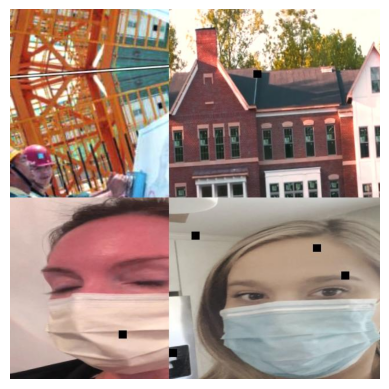

In [16]:
display_one_image(os.path.join(CFG.DATASET_PATH[0], 'train', 'images', '-1670-_png_jpg.rf.0463edb430019e01ec79eed27a6349d6.jpg')) # axis="off"

### visualise many images

In [17]:
def display_random_images(folder_path, num_images=10, seed=CFG.SEED):

    # fix seed to genere same value
    random.seed(seed)

    # check if the folder exist
    if os.path.isdir(folder_path):
        image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png', '.jpeg'))]

        # Randomly select num_images image files
        selected_files = random.sample(image_files, num_images)

        # Create a subplot grid
        num_cols = 5
        num_rows = (num_images + num_cols - 1) // num_cols
        fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 8))

        for i, file_name in enumerate(selected_files):
            # Open and display the image using PIL
            img = Image.open(os.path.join(folder_path, file_name))

            if num_rows == 1:
                ax = axes[i % num_cols]
            else:
                ax = axes[i // num_cols, i % num_cols]

            ax.imshow(img)
            ax.axis('off')
            print(f"image name : {file_name}")
        # Remove empty subplots
        for i in range(num_images, num_rows * num_cols):
            if num_rows == 1:
                fig.delaxes(axes[i % num_cols])
            else:
                fig.delaxes(axes[i // num_cols, i % num_cols])

        plt.tight_layout()
        plt.show()
    else:
        print(f"not found the folder :: {folder_path}")

image name : youtube-628_jpg.rf.062f20d445a5c8951bdebb2e64e3fd91.jpg
image name : construction-3-_mp4-23_jpg.rf.89d36ba8fa7060b226d63d08223458d9.jpg
image name : youtube-272_jpg.rf.bf7c90ad1b2d70c8a8cf63ec878b0aed.jpg
image name : image_1006_jpg.rf.54940aeca29eda3a51abe0cc917b0da9.jpg
image name : construction-369-_jpg.rf.23dd790f943919d62800543641ea8474.jpg
image name : p65621379_jpg.rf.0b6c6decc1f55d5fe6afe977125b858a.jpg
image name : construction-5-_mp4-48_jpg.rf.72bf6dca6741d8c2f2c96b9f9177b3e4.jpg
image name : youtube-554_jpg.rf.b18de4169917a75781361b42dcfede78.jpg
image name : youtube-693_jpg.rf.52fec3a45fb4c747d62c2b581d831c89.jpg
image name : 277_jpg.rf.e533863ccfdd0dba4c8d7089ef7b965d.jpg


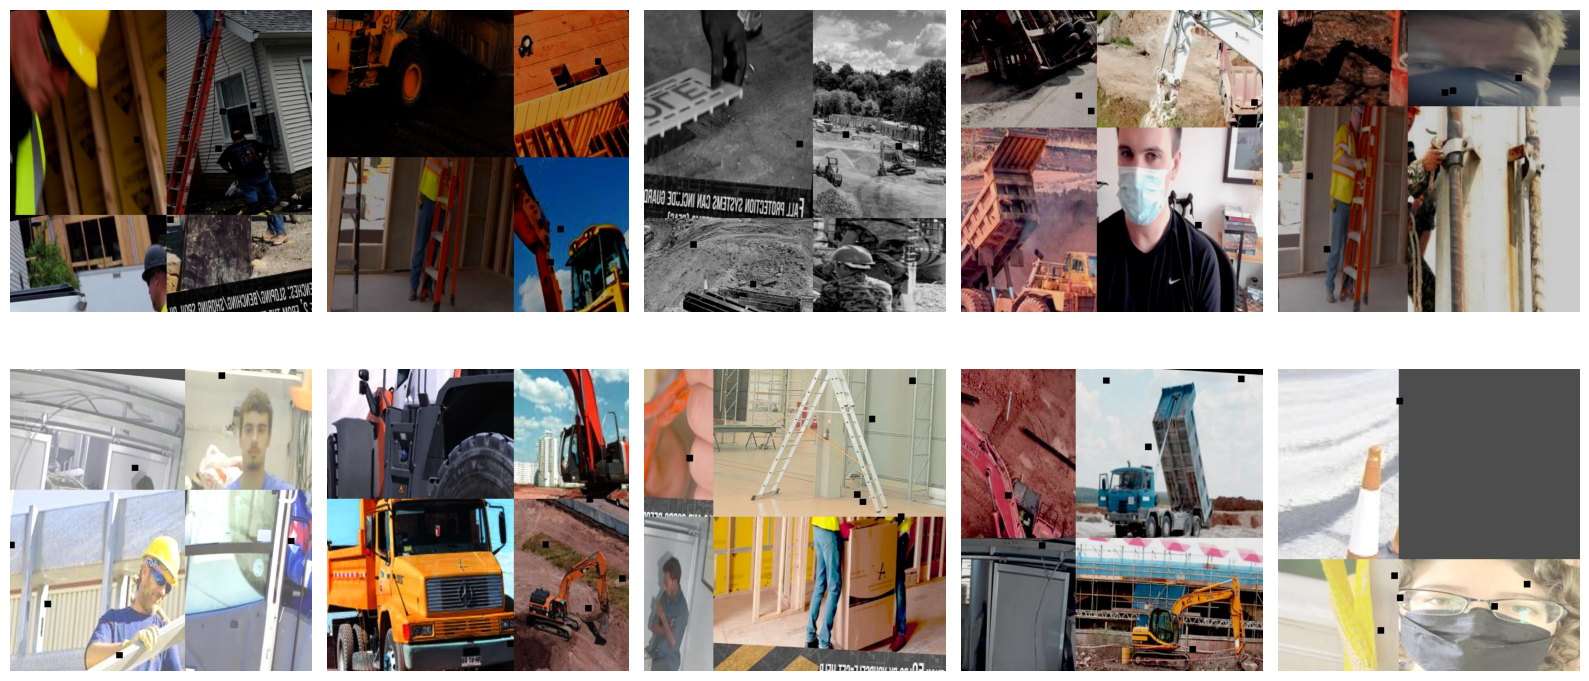

In [18]:
display_random_images(os.path.join(CFG.DATASET_PATH[0],'train', 'images'))

In [19]:
def plot_image_with_boxes(image_path, label_path):
    # Read image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Read annotations
    with open(label_path, 'r') as f:
        lines = f.readlines()

    # Draw bounding boxes
    for line in lines:
        class_id, x_center, y_center, width, height = map(float, line.split())
        h, w, _ = image.shape

        # Convert normalized coordinates to pixel values
        x_min = int((x_center - width / 2) * w)
        y_min = int((y_center - height / 2) * h)
        x_max = int((x_center + width / 2) * w)
        y_max = int((y_center + height / 2) * h)

        # Draw rectangle
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)

        # Display class_id near the top-left corner of the bounding box
        label_text = f"Class {int(class_id)}"
        # Position the text slightly above and to the left of the top-left corner of the box
        text_x = x_min
        text_y = y_max - 10   # Adjust the vertical offset as needed

        # Ensure the text doesn't go out of bounds
        # if text_y < 0:
        #     text_y = y_min + 10  # Place below the box if there's not enough space above

        cv2.putText(image, label_text, (text_x, text_y),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

    # Plot image
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis('off')
    plt.show()



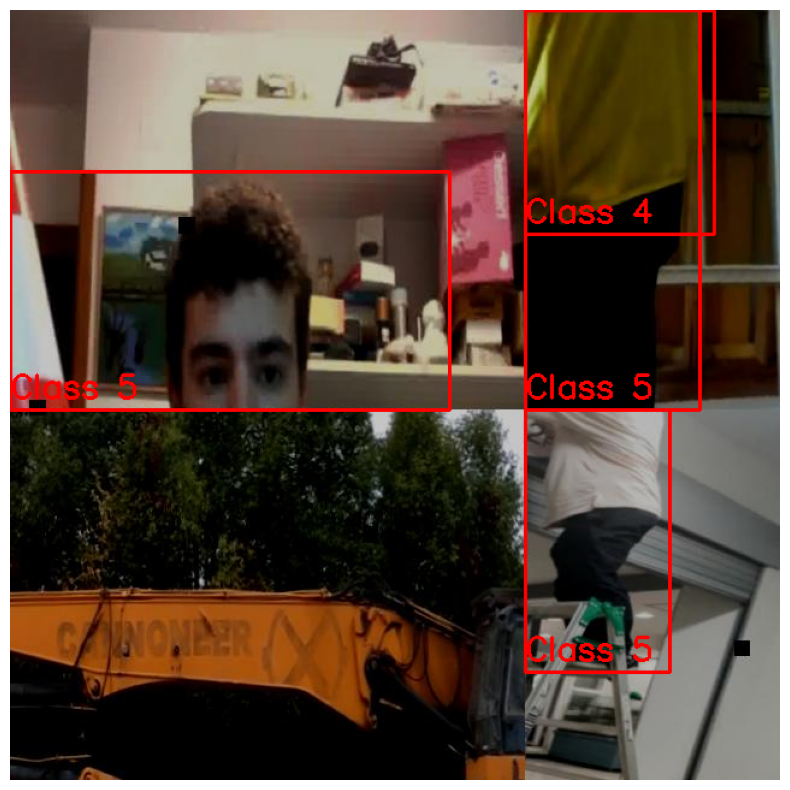

In [20]:
# Example usage
sample_image_path = os.path.join(CFG.DATASET_PATH[0], 'train', 'images', '60_jpg.rf.7605faf52324ab72b148018c8ed93813.jpg')
sample_label_path = os.path.join(CFG.DATASET_PATH[0], 'train', 'labels', '60_jpg.rf.7605faf52324ab72b148018c8ed93813.txt')
plot_image_with_boxes(sample_image_path, sample_label_path)

## Dataset statistics¶


In [21]:
def get_image_properties(image_path):
    # Read the image file
    img = cv2.imread(image_path)

    # Check if the image file is read successfully
    if img is None:
        raise ValueError("Could not read image file")

    # Get image properties
    properties = {
        "width": img.shape[1],
        "height": img.shape[0],
        "channels": img.shape[2] if len(img.shape) == 3 else 1,
        "dtype": img.dtype,
    }

    return properties

In [22]:
def statistics_of_dataset(folder_path):
    class_info = []
    if os.path.isdir(folder_path):

        for mode in CFG.MODE:

            path = os.path.join(folder_path, mode, 'labels')
            # Initialize dict class with zeros
            class_count = {CFG.CLASSES[i]: 0 for i in range(CFG.NUM_CLASSES_TO_TRAIN)}


            for file in os.listdir(path):

                with open(os.path.join(path, file), 'r') as f:
                    lines = f.readlines()

                    try :
                        for line in lines:
                            class_count[CFG.CLASSES[int(line[0])]] += 1
                    except Exception as e:
                        print(file, e)

            data_len = len(os.listdir(path))
            class_info.append({'Mode': mode, **class_count, "N-images": data_len})

    else:
        print(f"the folder not found")

    dataset_stats_df = pd.DataFrame(class_info)
    return dataset_stats_df


In [23]:
%%time
print(f"statistic of {CFG.DATASET_PATH[0]}")

dataset_stats_df = statistics_of_dataset(CFG.DATASET_PATH[0])

statistic of /content/data/Construction Site Safety Image Dataset/css-data/
1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.35ed51188a266a262a24924aa32463a0.txt list index out of range
1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.93dd6595c9b6f435a03af2e09588744c.txt list index out of range
1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.e65c339a3dc986701e765116332dba2d.txt list index out of range
1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.c0a0407a94e7eeb441a235b51752d178.txt list index out of range
1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.a988e2e512aa158adc5f82945a436de6.txt list index out of range
CPU times: user 68.9 ms, sys: 46.4 ms, total: 115 ms
Wall t

In [24]:
def visualize_statistics(stat_df):

    fig, axes = plt.subplots(1, 3, figsize=(16, 4))
    for i, mode in enumerate(CFG.MODE):
        sns.barplot(
            data=stat_df[stat_df["Mode"] == mode].drop(columns=["Mode",'N-images']),
            orient= 'v',
            ax=axes[i],
            palette= 'Set2'
        )

        # Add annotations on top of each bar
        for p in axes[i].patches:
            axes[i].annotate(f"{int(p.get_height())}", (p.get_x() + p.get_width() / 2., p.get_height()),
                         ha='center', va='center', fontsize=8, color='black', xytext=(0, 5),
                         textcoords='offset points')



visualize statistic of /content/data/Construction Site Safety Image Dataset/css-data/


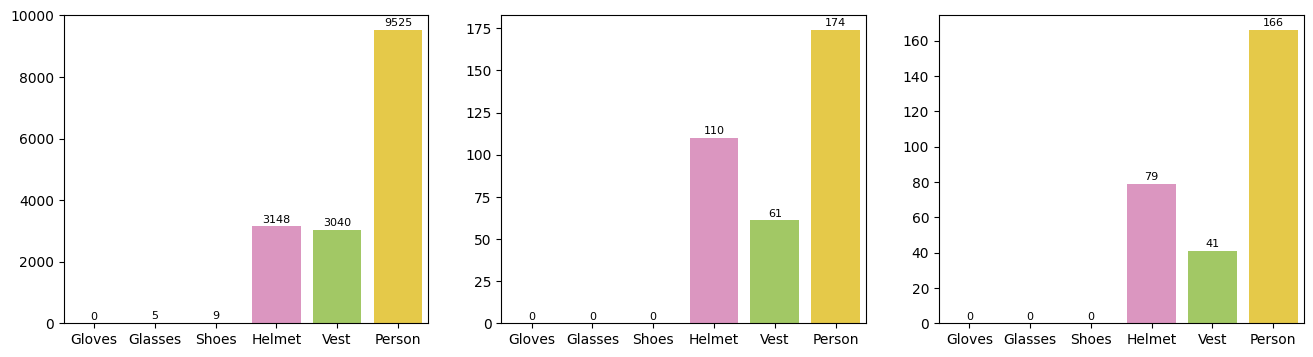

In [25]:
print(f"visualize statistic of {CFG.DATASET_PATH[0]}")

visualize_statistics(dataset_stats_df)

In [26]:

# Fonction pour copier les fichiers
def copy_data():
    for split in CFG.MODE:
        print(f"Traitement de {split}...")
        for dataset_path in CFG.DATASET_PATH:
            split_path = os.path.join(dataset_path, split)
            if not os.path.exists(split_path):
                print(f"Split {split} n'existe pas dans {dataset_path}, ignoré.")
                continue
            for class_name in os.listdir(split_path):
                class_path = os.path.join(split_path, class_name)
                if not os.path.isdir(class_path):
                    continue

                dest_dir = os.path.join(CFG.ARTIFACTS_DATA, split, class_name)
                os.makedirs(dest_dir, exist_ok=True)

                for filename in tqdm(os.listdir(class_path), desc=f"Copie {class_name} ({split}) depuis {dataset_path}"):
                    src_file = os.path.join(class_path, filename)
                    dest_file = os.path.join(dest_dir, filename)

                    # Pour éviter d'écraser si même nom de fichier
                    if os.path.exists(dest_file):
                        base, ext = os.path.splitext(filename)
                        counter = 1
                        while os.path.exists(dest_file):
                            dest_file = os.path.join(dest_dir, f"{base}_{counter}{ext}")
                            counter += 1

                    shutil.copy2(src_file, dest_file)


In [27]:
copy_data()

Traitement de train...


Copie images (train) depuis /content/data/Construction Site Safety Image Dataset/css-data/: 100%|██████████| 2605/2605 [00:29<00:00, 88.00it/s]
Copie labels (train) depuis /content/data/Construction Site Safety Image Dataset/css-data/: 100%|██████████| 2605/2605 [00:32<00:00, 80.31it/s]


Traitement de test...


Copie images (test) depuis /content/data/Construction Site Safety Image Dataset/css-data/: 100%|██████████| 82/82 [00:00<00:00, 82.25it/s]
Copie labels (test) depuis /content/data/Construction Site Safety Image Dataset/css-data/: 100%|██████████| 82/82 [00:01<00:00, 66.73it/s]


Traitement de valid...


Copie images (valid) depuis /content/data/Construction Site Safety Image Dataset/css-data/: 100%|██████████| 114/114 [00:01<00:00, 94.08it/s]
Copie labels (valid) depuis /content/data/Construction Site Safety Image Dataset/css-data/: 100%|██████████| 114/114 [00:01<00:00, 97.32it/s] 


In [ ]:
import shutil

# Compress all files in /kaggle/working/ into a ZIP archive
shutil.make_archive('/kaggle/working/dataset', 'zip', '/kaggle/working')

## Pre-processing


In [ ]:
def read_image(image_path, format_return : Literal['cv2', 'pil'] = 'cv2'):
        if format_return == 'cv2':
            return cv2.imread(image_path)
        else:
            return Image.open(image_path)


In [ ]:
# resizing image to be compatible with YOLO8
def resize_image(img, target_size=(640, 640)):
    return cv2.resize(img, target_size)

In [ ]:
def normalize_image(img):
    return img/255.0

In [ ]:
# def convert_to_gray(img):
#     return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

***adjust_brightness_contrast*** function uses a simple linear transformation to adjust brightness and contrast. Here's the underlying mathematical formula:

**New Intensity** = (**Contrast** × **Pixels**) + **Brightness**

**Contrast** == **alpha**

**Brightness** == **beta**

In [ ]:
def adjust_brightness_contrast(image, alpha=1.0, beta=0):
    return cv2.convertScaleAbs(image, alpha=alpha, beta=beta)(None)

## Data Augmentation

Data **augmentation** involves generating new variations of existing images to enrich the dataset and improve the robustness of the model.

we are going to do : mirroring, Random cropping, fliping, zoom, rotation and

In [ ]:
def augment_rotation_flip(image):
    # Flip horizontal
    flipped = cv2.flip(image, 1)
    # Rotate 90 degrees
    rotated = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    return flipped, rotated

In [ ]:
def scale_image(image, scale_factor=0.5):
    h, w = image.shape[:2]
    new_size = (int(w * scale_factor), int(h * scale_factor))
    return cv2.resize(image, new_size)

In [ ]:
def translate_image(image, x_shift, y_shift):
    rows, cols = image.shape[:2]
    M = np.float32([[1, 0, x_shift], [0, 1, y_shift]])
    return cv2.warpAffine(image, M, (cols, rows))

In [ ]:
def random_color_jitter(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hsv[..., 0] += random.randint(-10, 10)  # Hue
    hsv[..., 1] += random.randint(-30, 30)  # Saturation
    hsv[..., 2] += random.randint(-30, 30)  # Value
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

In [ ]:
def apply_gaussian_blur(image):
    return cv2.GaussianBlur(image, (5, 5), 0)

In [ ]:
sample_image_path = os.path.join(CFG.DATASET_PATH[0], 'train', 'images', 'image_4_jpg.rf.80f0e5e1cdf17a4c1984693b13904882.jpg')
